# Aprendizaje de embeddings supervisados

En las redes neuronales, los embeddings o representaciones vectoriales abstractas, son parte del aprendizaje de la red. Aquí presentamos una implementación de una red neuronal que estima los valores de relevancia entre un término y un documento, pero que además aprende las representaciones vectoriales de éstos.

In [1]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain
from operator import itemgetter
import numpy as np

### Preparación de los datos

Utilizamos el corpus Brown y pre-procesamos los datos aplicando una stopword, stemmer y pasando todo a minúsculas, así como eliminando caracteres no relevantes.

In [2]:
#Stopwords
paro = stopwords.words('english')
#Documentos de los tópicos considerados
ids = brown.fileids(categories=['romance'])[:5] + brown.fileids(categories=['religion'])[:5]
#Stemmer
stemmer = SnowballStemmer('english')

#Guarda las palabras
BagOfWords = defaultdict(list)
for i in ids:
    #Genera las palabras de cada documento
    words = brown.words(i)
    for w in words:
        #Aplica stopwords
        if w in paro or w.isalpha() == False:
            pass
        else:
            #Aplica stemmer y guarda
            BagOfWords[i].append(stemmer.stem(w))

print(BagOfWords.keys())

dict_keys(['cp01', 'cp02', 'cp03', 'cp04', 'cp05', 'cd01', 'cd02', 'cd03', 'cd04', 'cd05'])


Ahora creamos el conjunto de entrenamiento, el cual será un conjunto supervisado. Cada ejemplo de entrenamiento se conformará de tres elementos:

$$(d_i, t_j, y_{i,j})$$

$d_i$ (el documento) y $t_j$ (el término) serán la entrada de la red, mientras que $y_{i,j}$ será la salida de la red que es un valor de relevancia; en este caso tomamos como valor de relevancia la frecuencia.

In [3]:
#Frecuencia de términos
freqs = Counter(list(chain(*BagOfWords.values())))
#Índices para términos
terms = {w:k for k,w in enumerate(freqs.keys())}
#Índices para documentos
docs = {d:l for l,d in enumerate(BagOfWords.keys())}

#Crea el dataset de entrenamiento
train_set = []
for d, t_list in BagOfWords.items():
    doc_frec = Counter(t_list)
    for t, t_frec in doc_frec.items():
        train_set.append((docs[d], terms[t], t_frec))
        
print(train_set[:10])

[(0, 0, 4), (0, 1, 2), (0, 2, 4), (0, 3, 1), (0, 4, 16), (0, 5, 15), (0, 6, 3), (0, 7, 9), (0, 8, 2), (0, 9, 1)]


### Generación de la red

Nuestra red tomará dos entradas, el documento $d_i$ y el término $t_j$, cada uno de estos elementos pasará por una capa de embedding. De tal forma que tendremos un vector representado al documento y otro representado al término. Estos vectores se concatenan y pasan por capas densas hasta obtener una salida que será la predicción de la relevancia.

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

Utilizamos pytorch para definir la red como una clase RIModel.

In [6]:
#Número de documentos
n_docs = len(docs)
#Número de términos
n_terms = len(terms)

class RIModel(nn.Module):
    """
    Clase para definir la arquitectura de la red.
    """
    def __init__(self, emb_dims=128, h_dim=256):
        super().__init__()
        #dimensión de embeddings
        self.emb_dims = emb_dims
        #Embedding para documento
        self.emb_docs = nn.Embedding(n_docs, emb_dims)
        #Embedding para término
        self.emb_terms = nn.Embedding(n_terms, emb_dims)
        #Capas densas
        self.ffw = nn.Sequential(nn.Linear(2*emb_dims, 2*h_dim), nn.Tanh(),
                                 nn.Linear(2*h_dim, h_dim), nn.Tanh(),
                                 nn.Linear(h_dim, 1))
        
    def forward(self,x_doc, x_term):
        #Cálculo y concatenación de embeddings
        embs_concat = torch.cat((self.emb_docs(x_doc), self.emb_terms(x_term)), axis=1)
        #Aplicación de las capas densas
        out = self.ffw(embs_concat)
        
        return out

Ahora entrenamos la red con los datos de entrenamiento que hemos obtenido. Dado que queremos predecir valores reales, usamos el riesgo del error cuadrático. Usamos un optimizador Adam con rango de aprendizaje de 0.1 y corremos por 25 épocas.

In [7]:
%%time
#Definimos la red
net = RIModel(emb_dims=128, h_dim=256)
#Función de riesgo
risk = nn.MSELoss()
#Otpimizador
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
#Número de épocas
epochs = 25
for t in tqdm(range(epochs)):
    for d, t, s in train_set:
        #Creamos índices de documento y término en torch
        x_doc, x_term = torch.tensor([d]), torch.tensor([t])
        #Aplicamos la red
        pred = net(x_doc, x_term)
        #Damos formato a las salidas
        y = torch.tensor(s).reshape(1,1)
        y = y.to(torch.float32)
        #Calculamos el riesto
        loss = risk(pred, y)
        #Optimizamos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 25/25 [03:05<00:00,  7.44s/it]

CPU times: user 3min 5s, sys: 106 ms, total: 3min 5s
Wall time: 3min 6s


### Sistema de consulta 

A partir de la red podemos obtener el sistema de consulta. Podemos aplicar la red de manera directa para obtener los valores de relevancia que esta predice.

In [8]:
net.eval()
def consult(term):
    #Índice del término
    x_term = torch.tensor([terms[term]])
    for doc in docs.keys():
        #Índice para documentos en colección
        x_doc = torch.tensor([docs[doc]])
        
        #Devuelve la red entre término y documento
        yield ( doc, brown.categories(doc)[0], float(net(x_doc,x_term).detach()[0][0]) )

Podemos visualizar entonces el tipo de resultados que da en orden de relevancia.

In [9]:
result = consult('love')

for r in sorted(result, key=itemgetter(2), reverse=True):
    print(r)

('cp05', 'romance', 0.9988749027252197)
('cd02', 'religion', 0.9988749027252197)
('cd05', 'religion', 0.9988749027252197)
('cp01', 'romance', 0.9741750955581665)
('cp02', 'romance', 0.9741750955581665)
('cp03', 'romance', 0.9741750955581665)
('cp04', 'romance', 0.9741750955581665)
('cd01', 'religion', 0.9741750955581665)
('cd03', 'religion', 0.9741750955581665)
('cd04', 'religion', 0.9741750955581665)


### Uso de los embeddings

Además de entrenar la red para predecir la relevancia, hemos generado embeddings para términos y documentos. Estos embeddings en tanto representaciones vectoriales se pueden utilizar para hacer consultas como si se tratara de un modelo de espacio vectorial.

In [10]:
#Obtención de los embeddings a partir de la red
doc_embs = net.emb_docs.weight.detach().numpy()
term_embs = net.emb_terms.weight.detach().numpy()

def consult_embs(term):
    """
    Función de consulta a partir de embeddings.
    """
    #embedding de término
    t_vec = term_embs[terms[term]]
    
    for doc in docs.keys():
        #embeddings de documentos
        d_vec = doc_embs[docs[doc]]
        #Similitud coseno
        s = np.abs(np.dot(t_vec, d_vec))/( np.linalg.norm(t_vec)*np.linalg.norm(d_vec) ) 
        
        yield (doc, brown.categories(doc)[0], s)

Los resultados que se obtienen con estas consultas son los siguientes:

In [15]:
result = consult_embs('god')

for r in sorted(result, key=itemgetter(2), reverse=True):
    print(r)

('cd05', 'religion', 0.9335665)
('cp05', 'romance', 0.9017998)
('cd02', 'religion', 0.90087825)
('cd04', 'religion', 0.8960338)
('cd01', 'religion', 0.8324496)
('cp01', 'romance', 0.7515694)
('cp03', 'romance', 0.6937143)
('cd03', 'religion', 0.67838824)
('cp04', 'romance', 0.52966213)
('cp02', 'romance', 0.18644014)


Finalmente, podemos visualizar el cómo se comportan los embeddings en el espacio vectorial.

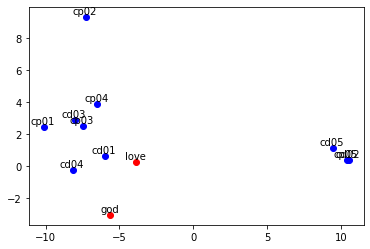

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Reducción de dimensionalidad
X = np.concatenate((doc_embs, term_embs))
red = PCA(n_components=2)
X_red = red.fit_transform(X)

#Función para visualizar los embeddings
#Usa reducción de la dimensionalidad por PCA
def plot(Z,ids, color='blue'):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
 
#Visualización de embeddings
plot(X_red[:10], docs.keys())
plot(X_red[10:][[terms['god'], terms['spirit']]], ['god','love'], color='red')